# data analysis ahead of modelling

## flag used in this script, checking them before running
- Test = "T1"/"T2"
- T3 = True/False
- woe_run -> True/False. 'True' will not trigger Test and T3

# Results: 

## no woe - best aucpr T1+T3  -> 0.49209293309370233¶, recall : 0.653353428786737
- saved dataset : "./selected_feature_T1_T3.p"

## with woe -> best aucpr 0.5191040225224578, recall : 0.6940467219291635
- saved dataset: "./woe_data_model/selected_feature_woe.p.p"

In [57]:
import pandas as pd
import xgboost as xgb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve, average_precision_score, accuracy_score

In [58]:
def remove_skewed_columns(df):
# this function was used to remove the column that has only one value
    for column in df:
        if len(df[column].unique()) == 1:
            df.drop(columns=column, inplace=True)
    return df

In [88]:
woe_run = True

In [89]:
# load the file
if woe_run:
    df = pd.read_csv("../woe_transformation/dataset_test_woed.csv", index_col=["ID"])
    df.drop( "Unnamed: 0", axis=1, inplace=True)
    df.rename(columns={"target": "default payment next month"}, inplace=True)
else:
    df = pd.read_csv("../credit_risk_data.csv", skiprows=1, index_col="ID")

df


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,0.692865,-0.079777,0.091416,0.076822,0.041466,2.065423,1.473415,-0.430029,-0.407307,-0.147246,...,0.061971,0.111703,0.056681,0.677342,0.012750,0.521223,0.463320,0.382161,0.361833,1
2,0.103760,-0.079777,0.091416,-0.072942,0.041466,-0.342752,1.473415,-0.295297,-0.235542,-0.200910,...,-0.341374,-0.383466,-0.434588,0.677342,0.053114,0.098836,0.046470,0.382161,0.007203,1
3,0.103760,-0.079777,0.091416,-0.072942,-0.161146,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,-0.023247,0.119063,0.121763,0.120994,0.174191,0.098836,0.046470,0.026641,-0.370422,0
4,0.273008,-0.079777,0.091416,0.076822,0.052545,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,0.178366,0.202243,0.226296,0.043100,-0.183815,-0.083967,0.046470,0.026641,-0.094260,0
5,0.273008,0.115154,0.091416,0.076822,0.052545,-0.342752,-0.406083,-0.430029,-0.235542,-0.200910,...,0.243437,0.247299,0.301036,0.043100,-1.125815,-0.541741,-0.449736,0.181627,0.236430,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,-0.302390,0.115154,0.168463,0.076822,0.052545,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,-0.006246,0.202243,0.121763,-0.491163,-1.125815,-0.544802,-0.316342,-0.452800,-0.094260,0
29997,-0.302390,0.115154,0.168463,-0.072942,0.052545,-0.342752,-0.402003,-0.430029,-0.407307,-0.200910,...,-0.030937,-0.383466,0.056681,0.043100,-0.126413,-0.290394,-0.086809,0.382161,0.361833,0
29998,0.651911,0.115154,0.091416,-0.072942,0.052545,2.199295,1.640054,1.319915,-0.407307,-0.200910,...,0.243437,0.101398,0.301036,0.677342,0.562642,-0.886388,-0.493851,0.017868,-0.253901,1


In [90]:
df = remove_skewed_columns(df)

In [91]:
df["EDUCATION"].unique()
df["SEX"].unique()
df.columns


Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

# zeros data processing

## T1:  defualt the unreasonable data to missing data and labeled 0
## T2:  defualt the unreasonable data to data value that appears most frequently
## T3:  pay status: change all negative to 0 and positive to 1 

In [92]:
Test = "T1"
T3 = True

In [93]:
# defualt the unreasonable data to missing data and labeled 0 
if not woe_run:
    if Test == "T1":
        df["EDUCATION"][df["EDUCATION"] == 5] = 0
        df["EDUCATION"][df["EDUCATION"] == 6] = 0
    elif Test == "T2":
        count = 0
        for i in range(5):
            if sum(df["EDUCATION"]==i) > count:
                count = sum(df["EDUCATION"]==i)
                max = i
        df["EDUCATION"][df["EDUCATION"] == 5] = max
        df["EDUCATION"][df["EDUCATION"] == 6] = max

    if T3:
        for i in [0, 2, 3, 4, 5, 6]:
            df["PAY_" + str(i)][df["PAY_" + str(i)] < 0] = 0
            df["PAY_" + str(i)][df["PAY_" + str(i)] > 0] = 1



In [94]:
# fit the model with all features
clf = LogisticRegression(random_state=10)
# seperate X and y
X = df.drop("default payment next month", axis=1).copy()
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
y = df["default payment next month"].copy()
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y, test_size=0.2, random_state = 8, stratify = y)

# Up sampling the training set -> 1s are much less than 0s

In [95]:
X_train.shape

(24000, 23)

In [96]:
scale_pos_weight = round(sum(abs(df["default payment next month"] - 1))/sum(df["default payment next month"]))
data_train = np.concatenate((X_train, np.array([y_train]).T), axis=1)
data_train_positive = data_train[data_train[:,-1]==1,:]

for i in range(scale_pos_weight):
    data_train = np.concatenate((data_train, data_train_positive), axis=0)
data_train.shape

(45236, 24)

In [97]:
clf.fit(data_train[:,:-1], data_train[:,-1])
predictions = clf.predict_proba(X_test)

In [98]:
predictions

array([[0.48694428, 0.51305572],
       [0.04559396, 0.95440604],
       [0.03296198, 0.96703802],
       ...,
       [0.22372856, 0.77627144],
       [0.70064416, 0.29935584],
       [0.60810638, 0.39189362]])

In [99]:
# calculate score
aucpr = average_precision_score(y_test, predictions[:,1])
aucpr

0.5191040225224578

In [100]:
recall_score(y_test, clf.predict(X_test))

0.6940467219291635

In [101]:
accuracy_score(y_test, clf.predict(X_test))

0.6886666666666666

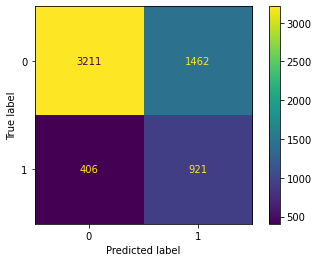

In [102]:
plot_confusion_matrix(clf, X_test, y_test)

# save 

In [104]:
pickle.dump({"X": scaled_X, "y": y, "scaler": scaler}, open("./woe_data_model/selected_feature_woe.p", "wb" ))